
# Вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

### Я постарался делать побольше коментариев и все подробно описывать в решении заданий 

## Задание 1
Retention – один из самых важных показателей в компании. 
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 
Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. 
В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [ ]:
# Импорт необходимы библиотек

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from tqdm.auto import tqdm

from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка датафрейма с регистрациями
reg_date = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/HXlF0W0XEVNang', sep=';')

In [ ]:
# Посмотрим на счасть данных
reg_date.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [ ]:
# Размер датафрейма
reg_date.shape

(1000000, 2)

In [ ]:
# Проверка на пустые значения (пустых значений нет)
reg_date.isnull().any()

reg_ts    False
uid       False
dtype: bool

In [ ]:
reg_date.duplicated().any()

False

In [ ]:
# Типы данных во всех столбцах int64
reg_date.dtypes

reg_ts    int64
uid       int64
dtype: object

In [ ]:
# Конвертируем дату из Timestamp в привычный формат и оставляем только необходимые столбцы
reg_date['reg_day'] = pd.to_datetime(reg_date['reg_ts'], unit='s').astype('datetime64[D]')
reg_day = reg_date[['uid','reg_day']]
reg_day.head()

,uid,reg_day
0,1,1998-11-18
1,2,1999-07-22
2,3,2000-01-13
3,4,2000-05-28
4,5,2000-09-16


In [ ]:
# Cудя по количеству строк в датафрейме, все пользователи уникальны
reg_day.nunique()

uid        1000000
reg_day       5110
dtype: int64

In [ ]:
# проведем дополнительную проверку
# посмотрим на min и max и тем самым проверим, что например нет uid с минусовыми значениями
reg_day.agg(['min','max'])

,uid,reg_day
min,1,1998-11-18
max,1110622,2020-09-23


In [ ]:
# Загружаем датасет с данными захода пользователей в игру
auth_data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/wBi5oBn_HR5zyg', sep=';')

In [ ]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [ ]:
# размер датафрейма
auth_data.shape

(9601013, 2)

In [ ]:
# Проверка на пустые значения (пустых значений нет)
auth_data.isnull().any()

auth_ts    False
uid        False
dtype: bool

In [ ]:
# типы данных
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [ ]:
# Конвертируем дату из Timestamp в привычный формат и оставляем только необходимые столбцы
auth_data['auth_day'] = pd.to_datetime(auth_data['auth_ts'], unit='s').astype('datetime64[D]')
auth_day = auth_data[['uid', 'auth_day']]
auth_day.head(3)

,uid,auth_day
0,1,1998-11-18
1,2,1999-07-22
2,2,1999-07-25


In [ ]:
# Посмотрим количество уникальных значений
# Судя по количеству уникальных uid, уже можно предположить, что здесь все uid из дата фрейма с регистрацией
auth_day.nunique()

uid         1000000
auth_day       6169
dtype: int64

In [ ]:
# проведем дополнительную проверку
# посмотрим на min и max и тем самым проверим, что например нет uid с минусовыми значениями
auth_day.agg(['min','max'])

,uid,auth_day
min,1,1998-11-18
max,1110622,2020-09-23


In [ ]:
# Объеденим датафреймы reg_day и auth_day
full_data = reg_day.merge(auth_day, on='uid', how='inner')
full_data.shape

(9601013, 3)

In [ ]:
full_data.head()

,uid,reg_day,auth_day
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


In [ ]:
# убедимся, что все пользователи на месте
reg_day['uid'].nunique() == auth_day['uid'].nunique() == full_data['uid'].nunique()

True

In [ ]:
# На всякий случай проверим на дубликаты
full_data.duplicated().any()

False

In [ ]:
# На всякий случай проверим на пустые значения
full_data.isnull().mean()

uid         0.0
reg_day     0.0
auth_day    0.0
dtype: float64

In [ ]:
# Так как, в датафрейме есть дни кога пользователи не заходили в игру, необходимо добавить все пропущенные даты

# Найдем минимальную и максимальную дату во всем дата фрейме
min_dt = full_data[['reg_day', 'auth_day']].min().to_frame()[0].min()
max_dt = full_data[['reg_day', 'auth_day']].max().to_frame()[0].max()
# Проранжируем даты от минимальной к максимальной
full_dt = pd.DataFrame(pd.date_range(min_dt, max_dt))
# Переименуем столбец в reg_day для удобства 
full_dt.columns=['reg_day']
# Объеденим датафреймы
full_date = full_dt.merge(full_data, how='left', on='reg_day')
full_date.head()

,reg_day,uid,auth_day
0,1998-11-18,1.0,1998-11-18
1,1998-11-19,NaN,NaT
2,1998-11-20,NaN,NaT
3,1998-11-21,NaN,NaT
4,1998-11-22,NaN,NaT


In [ ]:
# Проверим на наличие строк для каждого пользователя, 
# в которых дата времени входа меньше даты регистраци (такого быть не должно)
f = lambda x, y: x > y
f(full_date['reg_day'], full_date['auth_day']).sum()

0

# **Функция Retention**

### **Описание и функционал:**
Ниже представлена функция Retention, которая имеет несколько параметров, работает в нескольких режимах и делает следующие вещи:\
    1. Расчёт средних и медианных значений Retention в % для нескольких дней (1-й, 7-й, 14-й и 28-й день)\
    2. Построение линейного графика Retention в %  для заданного периода\
    3. Построение графика Heatmap для когортного анализа Retention в %  для заданного периода.

**Важно:** Построение графика Heatmap для когортного анализа всегда рассчитывается максимум за 30 дней (при большем количестве дней график становится слишком мелким).

### **Обязательные параметры:**
**df** – наименование датафрейма на основании которого будет рассчитываться Retention\
**user_id** - колонка с уникальным идентификатором для каждого пользователя\
**reg_days** - колонка с датой регистрации пользователя\
**actions_days** – колонка дат, когда этот пользователь выполнял действие (вход пользователя в игру и т.д.)

### **Необязательные параметры:**
   **days (по умолчанию = 30)**  - количество дней которое отсчитывается от указанных дат\
   **start_date (по умолчанию не задан)** – дата с которой необходимо начать расчет параметров и построение графиков\
   **end_date (по умолчанию не задан)** – дата с которой необходимо начать расчет параметров и построение графиков в обратном порядке или дата на которой необходимо закончить расчет параметров и построение графиков

**Примечания:**
	1. Дата actions_days  для конкретного пользователя всегда должна быть больше или равна значению reg_days
	2. Колонки с датами должны быть приведены к формату «datetime» и заданы следующим образом ‘yyyy-mm-dd’
	3. Параметр days может быть задан как числовым значением, так и аббревиатурой:
		'week' – 7 дней
		'2weeks' – 14 дней
		'month' – 30 дней
		'quarter' – 90 дней
		'year' – 365 дней
		'all' – весь период из датафрейма от минимальной даты до максимальной даты

### **Режим работы функции:**
  1. Заданы только обязательные параметры. В этом режиме функция рассчитывает все параметры и строит графики за последние 30 дней (значение по умолчанию)
  2.	Из необязательных параметров задан только параметр days. В этом режиме функция рассчитывает все параметры и строит графики за указанное количество дней.
  3.	Из необязательных параметров задан параметры start_date и end_date (параметр days в этом режиме игнорируется, даже если он задан). В этом режиме функция рассчитывает все параметры и строит графики за количество дней, находящихся между датами, заданными в параметрах start_date (включительно) и end_date (включительно)
  4.	Из необязательных параметров задан параметры days и start_date. В этом режиме функция рассчитывает все параметры и строит графики начиная с даты start_date (включительно) за N количество дней вперед, указанных в параметре days.
  5.	Из необязательных параметров задан параметры days и end_date. В этом режиме функция рассчитывает все параметры и строит графики за N количество дней, указанных в параметре days, заканчивающихся в дату end_date (включительно).
  6.	Из необязательных параметров задан только параметры start_date. В этом режиме функция рассчитывает все параметры и строит графики начиная с даты start_date (включительно) за 30 дней вперед.
  7.	Из необязательных параметров задан только параметры end_date. В этом режиме функция рассчитывает все параметры и строит графики за 30 предыдущих дней, заканчивающихся в дату end_date (включительно).


In [ ]:
def Retention(df, user_id, reg_days, actions_days, days=30, start_date=None, end_date=None):
    
    # переименуем стобцы для удобства
    data = df.rename(columns={user_id: 'user_id', reg_days: 'start_days', actions_days: 'actions_days'})
    
    # словарь с числовыми значениями временных интревалов заданных текстом
    dict_days = {'week': 7, '2weeks': 14, 'month': 30, 'quarter': 90, 'year': 365}
    
#--- Блок обработки переменых дней и дат------------------------------------ 
     
    if (start_date != None) and (end_date != None):
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)
            days = (end_date - start_date).days 
    elif (start_date != None) and (end_date == None) and (type(days) == int):
            days = days
            start_date = pd.to_datetime(start_date)
            end_date = start_date + timedelta(days= days - 1)
    elif (start_date == None) and (end_date != None) and (type(days) == int):
            days = days
            end_date = pd.to_datetime(end_date) 
            start_date = end_date - timedelta(days= days)
    elif (start_date != None) and (end_date == None) and (days in dict_days):
            days = dict_days[days]
            start_date = pd.to_datetime(start_date)
            end_date = start_date + timedelta(days= days - 1)
    elif (start_date == None) and (end_date != None) and (days in dict_days):
            days = dict_days[days]
            end_date = pd.to_datetime(end_date) 
            start_date = end_date - timedelta(days= days)        
    elif type(days) == int:
            days = days
            start_date = data['actions_days'].max() - timedelta(days=days)
            end_date = data['actions_days'].max()
    elif days == 'week':
            days = 7
            start_date = data['actions_days'].max() - timedelta(days=days)
            end_date = data['actions_days'].max()
    elif days == '2weeks':
            days = 7
            start_date = data['actions_days'].max() - timedelta(days=days)
            end_date = data['actions_days'].max()       
    elif days == 'month':
            days = 30
            start_date = data['actions_days'].max() - timedelta(days=days)
            end_date = data['actions_days'].max()
    elif days == 'quarter':
            days = 90
            start_date = data['actions_days'].max() - timedelta(days=days)
            end_date = data['actions_days'].max()
    elif days == 'year':
            days = 365
            start_date = data['actions_days'].max() - timedelta(days=days)
            end_date = data['actions_days'].max()
    elif days == 'all':
            start_date = data['start_days'].min()
            end_date = data['actions_days'].max()
            days = (end_date - start_date).days
    else:
            days = 30
            start_date = data['actions_days'].max() - timedelta(days=days)
            end_date = data['actions_days'].max()
        
#-- Retention -------------------------------------------------------             
        
    # отберем все данные за заданное количество дней
    query_data = data.query('@start_date <= start_days and actions_days <= @end_date') 
    
    # добаавим столбец с количеством активных дней пользователя
    query_data['lifetime'] = (query_data['actions_days'] - query_data['start_days']).dt.days

    # Подсчитаем количество уникальных пользователей
    count_unique_users = query_data['user_id'].nunique()

    # группируем пользователей по количеству дней
    users_by_day = query_data.groupby('lifetime').agg({'user_id': 'count'}).reset_index()
    
    # Считаем Retention в %  
    users_by_day['retention_rate'] = round(users_by_day['user_id']/count_unique_users, 4) * 100
    
#--- Когортный анализ -----------------------------------------------  
    
    # сгруппируем пользователей по когортам
    cohort_data = query_data.groupby(['start_days', 'lifetime'])['user_id'].apply(pd.Series.nunique).reset_index()

    # переведем дату в тип "строка" для наглядного отображения на графике
    cohort_data = cohort_data.astype({'start_days': str})

    # создадим матрицу когорт
    cohort_matrix = cohort_data.pivot_table(index = 'start_days', columns = 'lifetime', values = 'user_id')

    # Ограничим размер матрицы
    cohort_matrix = cohort_matrix.iloc[-31:, 0:31]

    # Подсчитаем размер когорт
    cohort_size = cohort_matrix.iloc[:,0]

    # Подсчитаем retention в %
    cohorts = cohort_matrix.divide(cohort_size, axis=0)

    # добавим статистику
    cohorts_stat = cohorts.agg(['mean', 'median'])
    cohorts_stat_space = cohorts_stat.append(pd.Series(name=' '))
    full_cohorts = pd.concat([cohorts_stat_space, cohorts])
    
#--- Создание датафрейма Retention по дням --------------------------------------
    
    # Из-за того, что на ранних датах мало данных, iloc выдавал ошибку когда не находил нужные колонки 
    # Пришлось усложнить обработку запроса, но все равно иногда выскакивает ошибка(
    
    a = list(cohorts_stat.columns.values)
    c = []
    
    if days < 7:
        b = [1]
        c = [i for i in b if i in a]
        retention_main_days = cohorts_stat.iloc[:, c]
    elif 7 <= days < 14:
        b = [1, 7]
        c = [i for i in b if i in a]
        retention_main_days = cohorts_stat.iloc[:, c]
    elif 14 <= days < 28:
        b = [1, 7, 14]
        c = [i for i in b if i in a]
        retention_main_days = cohorts_stat.iloc[:, c]
    else:
        b = [1, 7, 14, 28]
        c = [i for i in b if i in a]
        retention_main_days = cohorts_stat.iloc[:, c]
    
    retention_main_days = round(retention_main_days * 100, 2)
    retention_main_days = retention_main_days.rename(columns={1: 'day 1', 7: 'day 7', 14: 'day 14', 28: 'day 28'})
    
#--- Визуализизация 1-----------------------------------------------        
    
    # Если в графике 60 и менее дней, рисуются точки
    m = 0
    if days > 60 or days == 0:
        m = None 
    else:
        m = 'o'
        
    plt.figure(figsize=(16,5))
    sns.set_style('whitegrid')
    f = sns.lineplot(
                    x='lifetime', 
                    y='retention_rate', 
                    data=users_by_day,
                    marker=m,
                    )
    plt.title('Retention', pad=15)
    plt.xlabel('Days')
    plt.ylabel('Retention rate (%)')
    f.legend(users_by_day)

#--- Визуализизация 2 ------------------------------------------------ 

    # размеры щрифтов в heatmap
    font = 0
    if days > 30 or days == 0:
        font = 30 
    else:
        font = days
        
    font_1 = (font / 2) + 30 - font
    font_2 = (font / 2) + 32 - font
    font_3 = (font / 2) + 40 - font
    
    # поиск максимального значения во 2-й день и далее, для контрастного отображения
    max_percent = round(cohorts.iloc[:,1:].max().sort_values(ascending=False).reset_index()[0].max(), 1)

    # heatmap
    plt.figure(figsize= (26, 18))
    sns.heatmap(data = full_cohorts,
                annot = True, 
                fmt = '.0%',
                vmin = 0.0,
                vmax = max_percent,
                cmap = 'coolwarm',
                cbar=False,
                annot_kws={"fontsize":font_1})
    plt.yticks(rotation=0)
    plt.title('Cohort Analysis - Retention Rate', fontsize = font_3, pad=25) 
    plt.xlabel('Days', fontsize = font_3, labelpad=25)
    plt.ylabel('Cohort', fontsize = font_3, labelpad=15)
    plt.xticks(fontsize = font_2)
    plt.yticks(fontsize = font_2)
    
    return retention_main_days

### Результат работы функции Retention

,day 1,day 7,day 14,day 28
mean,2.02,5.82,4.51,2.66
median,1.95,5.95,4.51,3.13


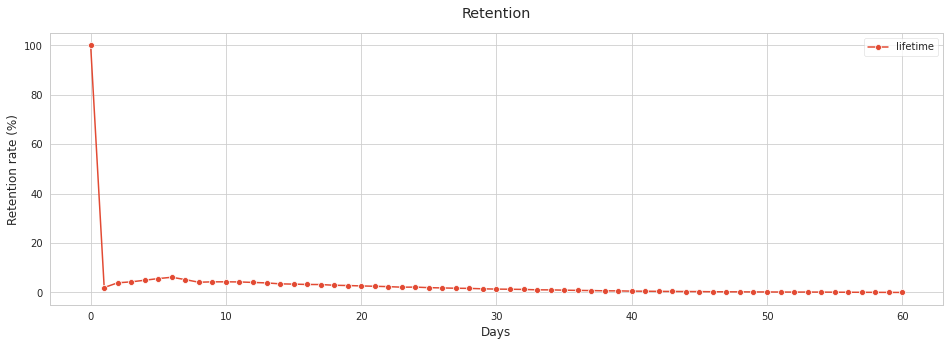

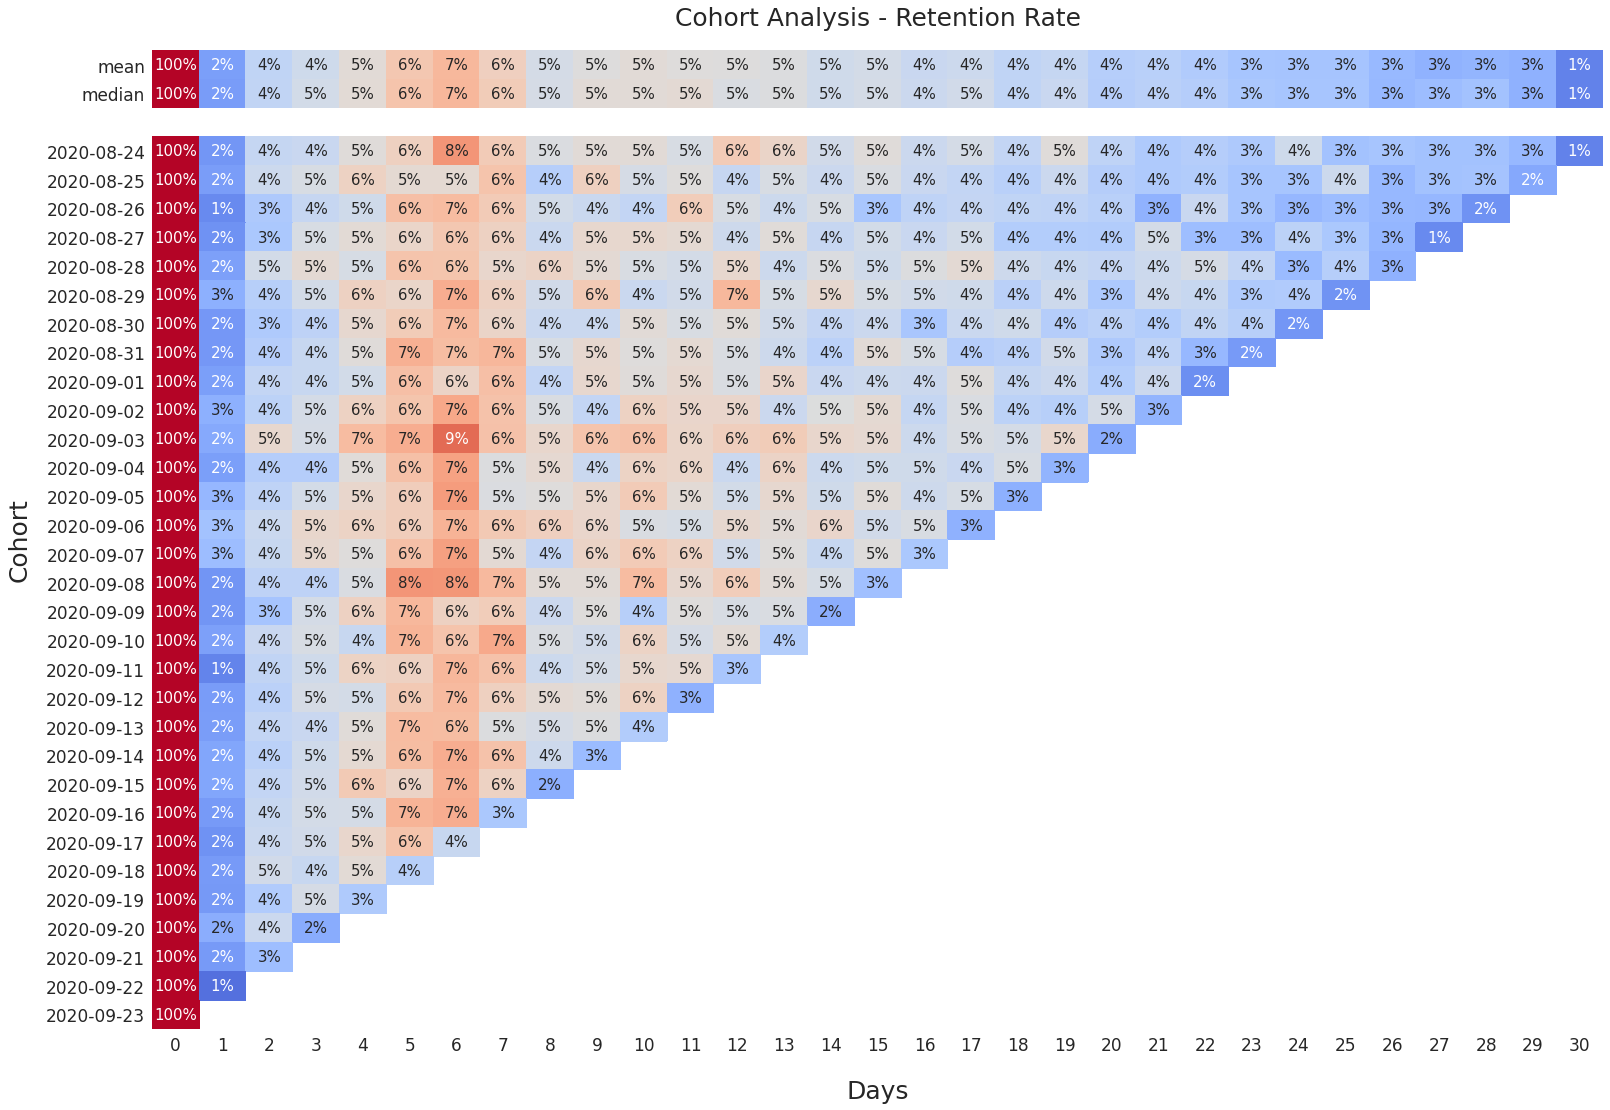

In [ ]:
Retention(full_date, 'uid', 'reg_day', 'auth_day', 60)

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [ ]:
# Загрузим данные
ab = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/ejoQ-1TzN4YkvA', sep=';')

In [ ]:
ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [ ]:
ab.info()
# У всех значений правильный тип
# Пропущенных значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [ ]:
ab.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [ ]:
ab['user_id'].nunique()
# Судя по количеству строк в датафрейме, все пользователи в датафрейме уникальные

404770

In [ ]:
# Подсчитаем основные метрики
ab_metrics = ab.groupby('testgroup', as_index=False).agg(users = ('user_id', 'count'),
                                                         paying_users = ('revenue', lambda x: sum(x > 0)),
                                                         revenue = ('revenue', 'sum'),
                                                         revenue_mean = ('revenue', 'mean'),
                                                         revenue_median = ('revenue', 'median')).round(2)

ab_metrics['ARPU'] = round(ab_metrics['revenue'] / ab_metrics['users'], 2)
ab_metrics['ARPPU'] = round(ab_metrics['revenue'] / ab_metrics['paying_users'], 2)
ab_metrics['paying_share'] = round((ab_metrics['paying_users'] / ab_metrics['users']) * 100, 2)

In [ ]:
# Подсчитаем медиану по каждому варианту среди ПЛАТЯЩИХ пользователей и назовем эту метрику MRPPU
ab_metrics['MRPPU'] = ab.groupby('testgroup', as_index=False).agg({'revenue': 'median'}).round(2)['revenue']

In [ ]:
ab_metrics

,testgroup,users,paying_users,revenue,revenue_mean,revenue_median,ARPU,ARPPU,paying_share,MRPPU
0,a,202103,1928,5136189,25.41,0,25.41,2664.00,0.95,0
1,b,202667,1805,5421603,26.75,0,26.75,3003.66,0.89,0


In [ ]:
# Отдельно посмотрим на платящих пользователй
paying_users = ab.query('revenue > 0')
paying_users.head(3)

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a


In [ ]:
# Посмотрим на данные в разрезе по всему датафрейму
paying_users.revenue.describe().to_frame()

,revenue
count,3733.000000
mean,2828.232521
std,6516.770722
min,200.000000
25%,309.000000
50%,2052.000000
75%,3126.000000
max,37433.000000


In [ ]:
# Посмотрим на данные в разрезе по группе А
paying_users.query('testgroup == "a"')['revenue'].describe().to_frame()

,revenue
count,1928.000000
mean,2663.998444
std,9049.039763
min,200.000000
25%,257.000000
50%,311.000000
75%,361.000000
max,37433.000000


In [ ]:
# Посмотрим на данные в разрезе по группе B
paying_users.query('testgroup == "b"')['revenue'].describe().to_frame()

,revenue
count,1805.000000
mean,3003.658172
std,572.619709
min,2000.000000
25%,2513.000000
50%,3022.000000
75%,3478.000000
max,4000.000000


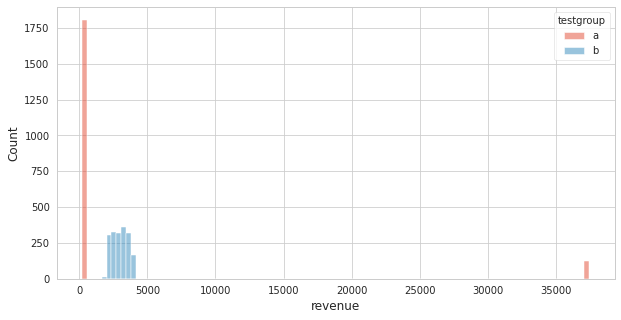

In [ ]:
# Посмотрим на выручку в виде графика
plt.figure(figsize=(10,5))
sns.histplot(data=paying_users, x="revenue", hue="testgroup")

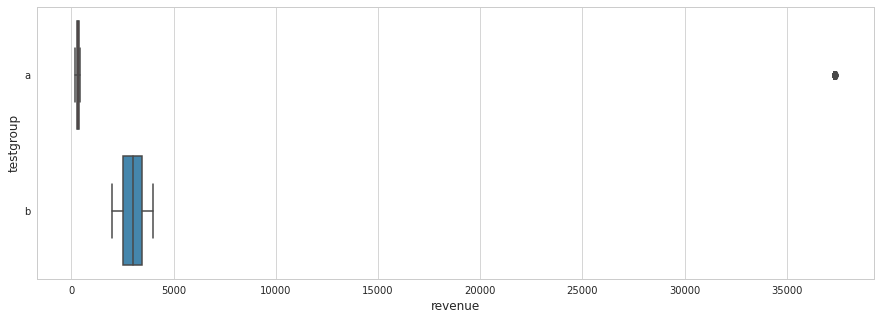

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=paying_users, x="revenue", y="testgroup")

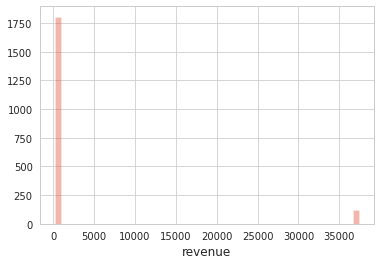

In [ ]:
# Отдельно по группе А
sns.distplot(paying_users[paying_users.testgroup == 'a'].revenue, kde=False)

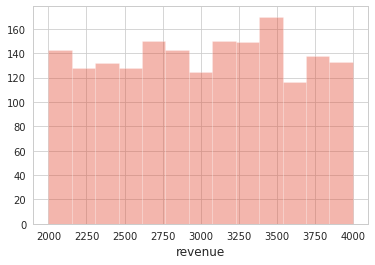

In [ ]:
# Отдельно по групе B
sns.distplot(paying_users[paying_users.testgroup == 'b'].revenue, kde=False)

**В качестве оценщика тестов я решил использовать Bootstrap, так как, он универсален, позволяет считать разную статистику и в данных есть сильные выбросы, которых Bootstrap не боится**

### Гипотезы:
**H0** - Что различий в данных нет\
**Н1** - Что различия в данных есть

In [ ]:
# Использовать будем функцию из лекции

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [ ]:
# Задаем параметры для функции
data = ab.copy()
boot_size = 1000

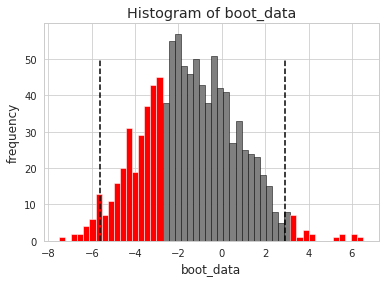

In [ ]:
booted_data_mean = get_bootstrap(
    data[data.testgroup == 'a'].revenue, # числовые значения первой выборки
    data[data.testgroup == 'b'].revenue, # числовые значения второй выборки
    boot_it = boot_size, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [ ]:
# Botstrap с подсчетом среднего
booted_data_mean["p_value"]

0.5142591719559644

### Значение p_value = 0.54 - Разница оказалась незначима

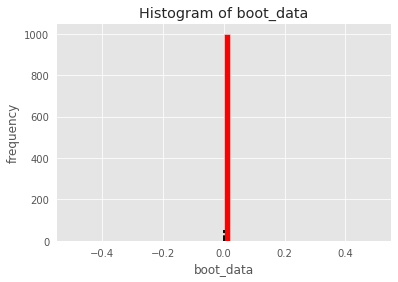

In [ ]:
# бутстрап (с np.median)
booted_data_median = get_bootstrap(
    data[data.testgroup == 'a'].revenue,
    data[data.testgroup == 'b'].revenue, 
    boot_it = boot_size, 
    statistic = np.median,
    bootstrap_conf_level = 0.95
)

In [ ]:
# При подсчете медианы Bootstrap выдает пустое значение
booted_data_median["p_value"]

nan

## Вывод: «вчера видел раков по 5, но больших, а сегодня – по 3, но маленькие»

На мой взгляд однозначного ответа по этому тесту дать нельзя.\
Молжно отдельно считать без выбросов, пользователей - Китов, но выкидывая топ юзеров из рассмотрения и принимая решение о раскатке теста на основе оставшихся пользователей, мы автоматически считаем, что топ юзеров поведёт себя также, как и остальные пользователи, или лучше. Что на самом деле может быть не так.\
С другой стороны, нужно помнить, что Киты - это самы лояльные пользователи, поэтому их нельзя убирать из выборки!

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. 
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. 
Для получения награды требуется пройти ряд уровней за определенное время. 
С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, 
что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 
Изменится ли набор метрик оценки результата? Если да, то как?

### Ответ на первую часть задания:

Я считаю, что как минимум необходимо смотреть на следующие метрики:\
**MAU, WAU, DAU** - так как, тематические события проходят ежемесячно и ограниченные по времени, необходимо отслеживать эти метрики. Значительные отклонения в большую или меньшую строну позволит оценить прошедшее событие за отслеживаемый период по соответствующей метрике. WAU и DAU - позволит оценить количество пользователей внутри события, а MAU - сравнивать тематические события между собой.

**Retantion** - Этот параметр также очень важен при оценке поведения посетителей, он позволит наглядно увидеть, как и в какие дни или часы пользователи реагировали на происходящие события. Тут логично предположить, что если Retantion увеличивается после определенного события, то событие понравилось пользователям и наоборот.\
**Churn** - по аналогии с Retantion только в обратную строну, позволит увидеть после какого события или череды событий происходит меньший или больший отток пользователей.\
**Средняя продолжительность сессии** - важный параметр, который позволит увидеть вовлеченность пользователей, чем он выше, тем более вовлечены наши пользователи, а значит они могут приносить больше выручки если, например монетизация игры состоит из показа рекламы.\
**Количество пройденных уровней за определенное время** - логично смотреть за дни, недели и месяцы. Другими словами, эта метрика, должна отражать, сколько уровней прошел каждый игрок в отдельности и все игроки вместе, если эта метрика растет, значит пользователям нравится играть в нашу игру.\
**Количество уникальных бонусов (монеты, предметы и т.д.) полученных пользователями за определённый период** - логично смотреть за дни, недели и месяцы.

На мой взгляд последние три метрики будут прямо отражать результаты последнего прошедшего события, если они будут расти или оставаться на уровнях выше среднего, то это будет означать, что пользователям нравится играть в нашу игру и получать эти награды несмотря на то, что для их получения необходимо пройти ряд уровней, да еще и за определенное время.


### Ответ на вторую часть задания:
Так как, в механику игры добавляются откаты на предыдущие уровни, то здесь обязательно стоит дополнить следующие метрики:\
**Количество откатов на предыдущий уровень** - если их будет слишком много, возможно стоит посмотреть сложность уровней, либо дополнить уровни бонусами (которые можно купить или заработать), которые будут помогать игрокам проходить уровни.\
**Информация о том, на каких сейчас уровнях находятся игроки** - например уровень 1 - 300 игроков, уровень 2- 200 игроков и т.д. Эта информация позволит оценить воронку прохождения уровней и даст ясность на каких уровнях какое количество игроков отваливается.\
**Необходима метрика последнего пройденного уровня для каждого пользователя**\
**Отдельно необходима метрика по количеству пройденных уровней по каждому пользователю**

Также в любых случаях и вариантах монетизации, обязательно необходимо смотреть на финансовые метрики в абсолютных выражениях и в динамике:\
**LTV**\
**ARPU**\
**ARPPU**\
**Paying Share**\
**Revenue**
